# Homework 4
Jonah Spicher

In [42]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import classes from thinkbayes2
from thinkbayes2 import Pmf, Suite, Joint, NormalPdf, MakeMixture

import thinkplot
import math
import numpy as np
from scipy.stats import norm

### Height Problem
The solution code was a lot prettier than mine so I definitely borrowed some of it. Sorry.

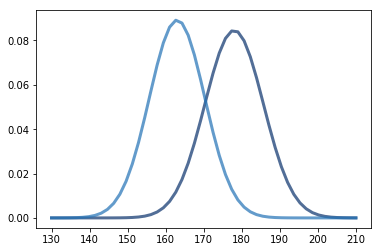

In [43]:
h_distribution = dict(male=norm(178, 7.7),
                   female=norm(163, 7.3))
hs = np.linspace(130, 210)
ps = dist_height['male'].pdf(hs)
male_height_pmf = Pmf(dict(zip(hs, ps)));
ps = dist_height['female'].pdf(hs)
female_height_pmf = Pmf(dict(zip(hs, ps)));
thinkplot.Pdf(male_height_pmf)
thinkplot.Pdf(female_height_pmf)

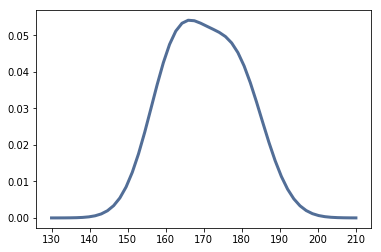

In [44]:
metapmf = Pmf({male_height_pmf:0.49, female_height_pmf:0.51})
mix = MakeMixture(metapmf)
thinkplot.Pdf(mix)

In [45]:
class Heights(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        """
        
        data: 'A' or 'B' is taller
        hypo: height of 1, 
        """
        h1, h2 = hypo
        if data == 'A':
            return 1 if h1 > h2 else 0
        else:
            return 1 if h2 > h1 else 0

In [5]:
def make_prior(A, B):
    suite = Heights()

    for h1, p1 in A.Items():
        for h2, p2 in B.Items():
            suite[h1, h2] = p1 * p2
    return suite

def faceoff(player1, player2, data):
    """Compute the posterior distributions for both players.
    
    player1: Pmf
    player2: Pmf
    data: margin by which player1 beats player2
    """
    joint = make_prior(player1, player2)
    joint.Update(data)
    return joint.Marginal(0), joint.Marginal(1)

181.60660153115964

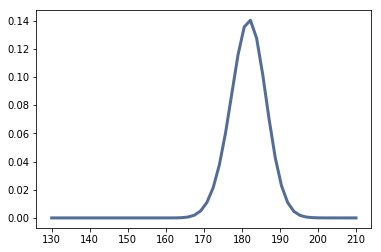

In [6]:
A = mix
B = mix
for i in range(8):
    A, _ = faceoff(A, B, 'A')
    
A, B = faceoff(A, B, 'B');

thinkplot.Pdf(A)
A.Mean()

### Lincoln Index Problem
My solution seems to agree with the lincoln index pretty well, though I am concerned that it might not take into account the possibility that one tester is better than the other.

In [7]:
from scipy.special import binom

class Bugs(Suite):
    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        hypo: total bugs (N)
        data: # caught by first tester (K), # caught by second tester (n), # caught by both (k)
        """
        N = hypo
        K, n, k = data

        if hypo < K + (n - k):
            return 0

        like = binom(N-K, n-k) / binom(N, n)
        return like

20

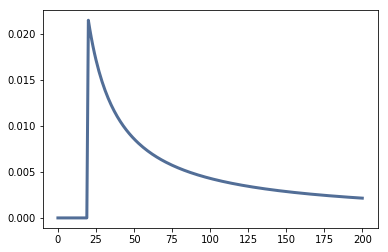

In [8]:
hypos = range(0, 201)
suite = Bugs(hypos)

data = 20, 1, 1
suite.Update(data)
thinkplot.plot(suite)
suite.MAP()

In [9]:
def lincoln_index(n1, n2, c):
    return n1*n2/c

In [10]:
lincoln_index(20, 15, 3)

100.0

### Skeet Problem
It should be fair to represent each shooter as a beta distribution, where heads and tails are hits and misses.

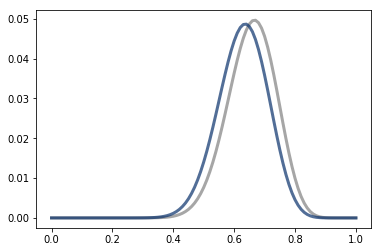

In [17]:
from thinkbayes2 import Beta
rhode = Beta()
meng = Beta()
r_hits = 15+1+2+2+2
r_misses = 10+1
m_hits = 15+1+2+2+1
m_misses = 10+1+1
rhode.Update((r_hits, r_misses))
meng.Update((m_hits, m_misses))
rhode = rhode.MakePmf()
meng = meng.MakePmf()
thinkplot.plot(rhode, color='grey')
thinkplot.plot(meng)

Then, we can pit the shooters against eachother in several thousand matches, until they converge on a defintie overall winner.

In [26]:
import random
def flip(p):
    return True if random.random() < p  else False

def rematch(r, m, num_matches):
    outcomes = [0, 0, 0] # rwins, mwins, ties
    for i in range(num_matches):
        r_total = 0
        m_total = 0
        
        r_ps = r.Sample(25)
        m_ps = m.Sample(25)
        
        for i in range(25):
            
            if flip(r_ps[i]):
                r_total += 1
            if flip(m_ps[i]):
                m_total += 1
        if r_total > m_total:
            outcomes[0] += 1
        elif r_total < m_total:
            outcomes[1] += 1
        else:
            outcomes[2] += 1
    return outcomes
        

In [30]:
num_matches = 100000
outcomes = rematch(rhode, meng, num_matches)

[52318, 36281, 11401]

In [32]:
r_winrate = outcomes[0] / num_matches
m_winrate = outcomes[1] / num_matches
tie_rate = outcomes[2] / num_matches
print(r_winrate, m_winrate)

0.52318 0.36281


It looks like in the longterm, rhode will win more games than meng, though that is largely because a large portion of their games end in tied. Rhode only wins a little more than half of the time. 

### Social Desirability Problem
The result for this problem is bizarrely jagged, which suggests I did something wrong. Maybe I need a distribution for the number of people who flip heads who are atheist vs not?

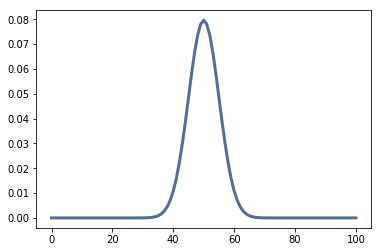

In [36]:
from thinkbayes2 import MakeBinomialPmf
heads_dist = MakeBinomialPmf(100, 0.5)
thinkplot.plot(heads_dist)

In [37]:
class something(Suite):
    def Likelihood(self, data, hypo):
        """
        data: number of people who answered 'yes'
        hypo: number of people we think believe in god
        """
        total = 0
        for num, p in heads_dist.Items():
            if data < num:
                total += 0
            else:
                frac = (data - num) / (100 - num)
                if round(frac*100) == hypo:
                    total += p
                else:
                    total += 0
        return total
            

59.61545373512311

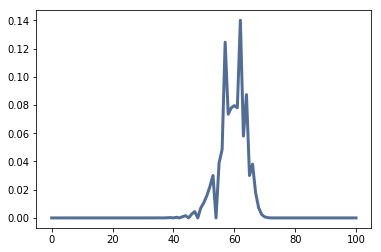

In [38]:
people = something(range(0, 101))
people.Update(80)
thinkplot.plot(people)
people.Mean()

### Volunteer Problem

In [46]:
class volunteers(Suite, Joint):
    def Likelihood(self, data, hypo):
        """
        data: number reported back
        hypo: a tuple: (prob participating, prob reporting back)
        """
        like = 1
        return like

### Project Ideas

1. Civilization win rates based on starting factors, similar to what is done [here](https://civscience.wordpress.com/)

2. Not sure if this counts as a pitch because you posted it, but estimating the number of atheists in the US looked like an intersting problem.

3. Something in linguistics, an example that's maybe silly is guessing what language an unknown word is based on the letters or phonemes it contains. Alternatively, something with Grimms law (and the equivalent for other languages) and finding the likelihood that different words come from Proto-Indo-European (this is based on sound shifts different languages underwent, some reading [here](https://en.wikipedia.org/wiki/Proto-Indo-European_language) and [here](https://en.wikipedia.org/wiki/Comparative_method) if you are curious). This is almost defintiely overscoped though, even if statistical methods can even be applied here. 